In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
np.random.RandomState(42)

import time
import datetime as dt
from scipy import stats
import seaborn as sns

from holidays import country_holidays
from sklearn import preprocessing

In [2]:
#get train and test data
train_data = pd.read_parquet(Path("data") / "train.parquet")
test_data = pd.read_parquet(Path("data") / "test.parquet")

In [3]:
#get external(weather) data for 2020 and 2021
df1 = pd.read_csv('2020.csv')
df2 = pd.read_csv('2021.csv')

In [4]:
df2

,date,hour,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,Coco
0,2021-01-01,0,1.6,-0.8,84,NaN,NaN,280,7.6,NaN,1008.0,NaN,NaN
1,2021-01-01,1,1.4,-1.0,84,0.0,NaN,280,5.4,NaN,1008.2,NaN,NaN
2,2021-01-01,2,0.9,-1.2,86,0.0,NaN,280,5.4,NaN,1008.6,NaN,NaN
3,2021-01-01,3,0.8,-1.1,87,NaN,NaN,280,5.4,NaN,1008.9,NaN,NaN
4,2021-01-01,4,0.6,-1.3,87,0.0,NaN,310,3.6,NaN,1009.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2021-12-31,19,11.9,10.3,90,0.0,NaN,250,5.4,NaN,1026.5,NaN,NaN
8756,2021-12-31,20,12.0,10.6,91,0.0,NaN,280,11.2,NaN,1026.6,NaN,NaN
8757,2021-12-31,21,12.2,10.9,92,0.0,NaN,280,7.6,NaN,1026.6,NaN,NaN
8758,2021-12-31,22,12.0,10.6,91,0.0,NaN,270,3.6,NaN,1026.7,NaN,NaN


> Apart from weather, the cyclist traffic will also depend on specific days such as weekday/weekend of public hoplidays, so we will add that data accordingly

In [5]:
#list of public holidays in both years to label if a given day is holiday or not
public_holi20 = country_holidays('FR', subdiv='La Réunion', years=[2020])
public_holi21 = country_holidays('FR', subdiv='La Réunion', years=[2021])

In [6]:
# for 2020 add holiday and weekend column, replace true and false as 1 and 0
df1["date"] = pd.to_datetime(df1["date"])
df1['holiday'] = df1['date'].isin(public_holi20)
df1.holiday = df1.holiday.replace([True, False], [1, 0])
df1.loc[:, "weekday"] = df1["date"].dt.weekday
df1['weekend'] = df1['weekday'].isin([5,6])
df1.weekend = df1.weekend.replace([True, False], [1, 0])
df1 = df1.drop('weekday', axis=1)
df1

,date,hour,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,holiday,weekend
0,2020-01-01,0,0.8,-0.1,94,NaN,NaN,170.0,5.4,NaN,1032.5,NaN,NaN,1,0
1,2020-01-01,1,-0.7,-1.3,96,0.0,NaN,200.0,9.4,NaN,1032.2,NaN,NaN,1,0
2,2020-01-01,2,-0.3,-0.6,98,0.0,NaN,190.0,7.6,NaN,1032.2,NaN,NaN,1,0
3,2020-01-01,3,0.0,-0.3,98,NaN,NaN,220.0,5.4,NaN,1031.9,NaN,NaN,1,0
4,2020-01-01,4,0.3,0.0,98,0.0,NaN,210.0,7.6,NaN,1031.6,NaN,NaN,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8651,2020-12-31,19,4.0,0.2,76,0.0,NaN,300.0,7.6,NaN,1006.3,NaN,NaN,0,0
8652,2020-12-31,20,3.2,-0.1,79,0.0,NaN,310.0,5.4,NaN,1006.6,NaN,NaN,0,0
8653,2020-12-31,21,3.0,-0.3,79,NaN,NaN,330.0,7.6,NaN,1007.0,NaN,NaN,0,0
8654,2020-12-31,22,2.5,-0.4,81,0.0,NaN,280.0,5.4,NaN,1007.5,NaN,NaN,0,0


In [7]:
#do the same above process for 2021
df2["date"] = pd.to_datetime(df2["date"])
df2['holiday'] = df2['date'].isin(public_holi21)
df2.holiday = df2.holiday.replace([True, False], [1, 0])
df2.loc[:, "weekday"] = df2["date"].dt.weekday
df2['weekend'] = df2['weekday'].isin([5,6])
df2.weekend = df2.weekend.replace([True, False], [1, 0])
df2 = df2.drop('weekday', axis=1)
df2

,date,hour,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,Coco,holiday,weekend
0,2021-01-01,0,1.6,-0.8,84,NaN,NaN,280,7.6,NaN,1008.0,NaN,NaN,1,0
1,2021-01-01,1,1.4,-1.0,84,0.0,NaN,280,5.4,NaN,1008.2,NaN,NaN,1,0
2,2021-01-01,2,0.9,-1.2,86,0.0,NaN,280,5.4,NaN,1008.6,NaN,NaN,1,0
3,2021-01-01,3,0.8,-1.1,87,NaN,NaN,280,5.4,NaN,1008.9,NaN,NaN,1,0
4,2021-01-01,4,0.6,-1.3,87,0.0,NaN,310,3.6,NaN,1009.0,NaN,NaN,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2021-12-31,19,11.9,10.3,90,0.0,NaN,250,5.4,NaN,1026.5,NaN,NaN,0,0
8756,2021-12-31,20,12.0,10.6,91,0.0,NaN,280,11.2,NaN,1026.6,NaN,NaN,0,0
8757,2021-12-31,21,12.2,10.9,92,0.0,NaN,280,7.6,NaN,1026.6,NaN,NaN,0,0
8758,2021-12-31,22,12.0,10.6,91,0.0,NaN,270,3.6,NaN,1026.7,NaN,NaN,0,0


In [8]:
weather = pd.concat([df1, df2], ignore_index=True)

In [9]:
weather

,date,hour,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,holiday,weekend,Coco
0,2020-01-01,0,0.8,-0.1,94,NaN,NaN,170.0,5.4,NaN,1032.5,NaN,NaN,1,0,NaN
1,2020-01-01,1,-0.7,-1.3,96,0.0,NaN,200.0,9.4,NaN,1032.2,NaN,NaN,1,0,NaN
2,2020-01-01,2,-0.3,-0.6,98,0.0,NaN,190.0,7.6,NaN,1032.2,NaN,NaN,1,0,NaN
3,2020-01-01,3,0.0,-0.3,98,NaN,NaN,220.0,5.4,NaN,1031.9,NaN,NaN,1,0,NaN
4,2020-01-01,4,0.3,0.0,98,0.0,NaN,210.0,7.6,NaN,1031.6,NaN,NaN,1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17411,2021-12-31,19,11.9,10.3,90,0.0,NaN,250.0,5.4,NaN,1026.5,NaN,NaN,0,0,NaN
17412,2021-12-31,20,12.0,10.6,91,0.0,NaN,280.0,11.2,NaN,1026.6,NaN,NaN,0,0,NaN
17413,2021-12-31,21,12.2,10.9,92,0.0,NaN,280.0,7.6,NaN,1026.6,NaN,NaN,0,0,NaN
17414,2021-12-31,22,12.0,10.6,91,0.0,NaN,270.0,3.6,NaN,1026.7,NaN,NaN,0,0,NaN


In [10]:
lock1 = pd.date_range(start='10/30/2020', end='12/02/2020', freq='H').tolist()
lock2 = pd.date_range(start='04/03/2021', end='07/01/2021', freq='H').tolist()

> The bike count in years 2020 and 2021 would have also been affected by the lockdowns imposed in the country. Therefore we take into consideration that data too

In [11]:
weather['lockdown1'] = weather['date'].isin(lock1)
weather.lockdown1 = weather.lockdown1.replace([True, False], [1, 0])
weather['lockdown2'] = weather['date'].isin(lock2)
weather.lockdown2 = weather.lockdown2.replace([True, False], [1, 0])

In [12]:
weather

,date,hour,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,holiday,weekend,Coco,lockdown1,lockdown2
0,2020-01-01,0,0.8,-0.1,94,NaN,NaN,170.0,5.4,NaN,1032.5,NaN,NaN,1,0,NaN,0,0
1,2020-01-01,1,-0.7,-1.3,96,0.0,NaN,200.0,9.4,NaN,1032.2,NaN,NaN,1,0,NaN,0,0
2,2020-01-01,2,-0.3,-0.6,98,0.0,NaN,190.0,7.6,NaN,1032.2,NaN,NaN,1,0,NaN,0,0
3,2020-01-01,3,0.0,-0.3,98,NaN,NaN,220.0,5.4,NaN,1031.9,NaN,NaN,1,0,NaN,0,0
4,2020-01-01,4,0.3,0.0,98,0.0,NaN,210.0,7.6,NaN,1031.6,NaN,NaN,1,0,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17411,2021-12-31,19,11.9,10.3,90,0.0,NaN,250.0,5.4,NaN,1026.5,NaN,NaN,0,0,NaN,0,0
17412,2021-12-31,20,12.0,10.6,91,0.0,NaN,280.0,11.2,NaN,1026.6,NaN,NaN,0,0,NaN,0,0
17413,2021-12-31,21,12.2,10.9,92,0.0,NaN,280.0,7.6,NaN,1026.6,NaN,NaN,0,0,NaN,0,0
17414,2021-12-31,22,12.0,10.6,91,0.0,NaN,270.0,3.6,NaN,1026.7,NaN,NaN,0,0,NaN,0,0


In [13]:
# add season as a numerical column depending on the month of the year
"""
mapping:
0 - spring
1 - summer
2 - fall
3 - winter
"""
weather.loc[:, "season"] = weather["date"].dt.month
weather.season = weather.season.replace([1,2,3,4,5,6,7,8,9,10,11,12], [3,3,3,0,0,1,1,1,1,2,2,3])
weather

,date,hour,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,holiday,weekend,Coco,lockdown1,lockdown2,season
0,2020-01-01,0,0.8,-0.1,94,NaN,NaN,170.0,5.4,NaN,1032.5,NaN,NaN,1,0,NaN,0,0,3
1,2020-01-01,1,-0.7,-1.3,96,0.0,NaN,200.0,9.4,NaN,1032.2,NaN,NaN,1,0,NaN,0,0,3
2,2020-01-01,2,-0.3,-0.6,98,0.0,NaN,190.0,7.6,NaN,1032.2,NaN,NaN,1,0,NaN,0,0,3
3,2020-01-01,3,0.0,-0.3,98,NaN,NaN,220.0,5.4,NaN,1031.9,NaN,NaN,1,0,NaN,0,0,3
4,2020-01-01,4,0.3,0.0,98,0.0,NaN,210.0,7.6,NaN,1031.6,NaN,NaN,1,0,NaN,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17411,2021-12-31,19,11.9,10.3,90,0.0,NaN,250.0,5.4,NaN,1026.5,NaN,NaN,0,0,NaN,0,0,3
17412,2021-12-31,20,12.0,10.6,91,0.0,NaN,280.0,11.2,NaN,1026.6,NaN,NaN,0,0,NaN,0,0,3
17413,2021-12-31,21,12.2,10.9,92,0.0,NaN,280.0,7.6,NaN,1026.6,NaN,NaN,0,0,NaN,0,0,3
17414,2021-12-31,22,12.0,10.6,91,0.0,NaN,270.0,3.6,NaN,1026.7,NaN,NaN,0,0,NaN,0,0,3


In [14]:
train_data.loc[:, "hour"] = train_data["date"].dt.hour
train_data[train_data['log_bike_count']<3.5].groupby(by='hour').count()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,log_bike_count
hour,,,,,,,,,,,
0,18440,18440,18440,18440,18440,18440,18440,18440,18440,18440,18440
1,18861,18861,18861,18861,18861,18861,18861,18861,18861,18861,18861
2,18944,18944,18944,18944,18944,18944,18944,18944,18944,18944,18944
3,18958,18958,18958,18958,18958,18958,18958,18958,18958,18958,18958
4,18222,18222,18222,18222,18222,18222,18222,18222,18222,18222,18222
5,13690,13690,13690,13690,13690,13690,13690,13690,13690,13690,13690
6,8035,8035,8035,8035,8035,8035,8035,8035,8035,8035,8035
7,5553,5553,5553,5553,5553,5553,5553,5553,5553,5553,5553
8,5563,5563,5563,5563,5563,5563,5563,5563,5563,5563,5563


> The grouping above shows that hourly grouping is separating the two distributions. The daylight could be a crucial factor that is creating two distributions of the data. A new column "is_night" is created that is approximately separating the data.

In [15]:
weather['is_night'] = 0
weather.loc[(weather['hour'] < 6) | (weather['hour'] > 19), 'is_night'] = 1
weather

,date,hour,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,holiday,weekend,Coco,lockdown1,lockdown2,season,is_night
0,2020-01-01,0,0.8,-0.1,94,NaN,NaN,170.0,5.4,NaN,1032.5,NaN,NaN,1,0,NaN,0,0,3,1
1,2020-01-01,1,-0.7,-1.3,96,0.0,NaN,200.0,9.4,NaN,1032.2,NaN,NaN,1,0,NaN,0,0,3,1
2,2020-01-01,2,-0.3,-0.6,98,0.0,NaN,190.0,7.6,NaN,1032.2,NaN,NaN,1,0,NaN,0,0,3,1
3,2020-01-01,3,0.0,-0.3,98,NaN,NaN,220.0,5.4,NaN,1031.9,NaN,NaN,1,0,NaN,0,0,3,1
4,2020-01-01,4,0.3,0.0,98,0.0,NaN,210.0,7.6,NaN,1031.6,NaN,NaN,1,0,NaN,0,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17411,2021-12-31,19,11.9,10.3,90,0.0,NaN,250.0,5.4,NaN,1026.5,NaN,NaN,0,0,NaN,0,0,3,0
17412,2021-12-31,20,12.0,10.6,91,0.0,NaN,280.0,11.2,NaN,1026.6,NaN,NaN,0,0,NaN,0,0,3,1
17413,2021-12-31,21,12.2,10.9,92,0.0,NaN,280.0,7.6,NaN,1026.6,NaN,NaN,0,0,NaN,0,0,3,1
17414,2021-12-31,22,12.0,10.6,91,0.0,NaN,270.0,3.6,NaN,1026.7,NaN,NaN,0,0,NaN,0,0,3,1


In [16]:
train_data = train_data.drop('hour', axis=1)

> We can see from above that some columns like snow, tsun, coco, etc have no values. Therefore we remove these columns as they are incompatible with some scikit-learn estimators which assume that all values in an array are numerical, and that all have and hold meaning. We will also impute the prcp column using bfill

In [17]:
weather = weather.drop(columns=['snow', 'wpgt','tsun','coco','Coco'], axis=1)
weather = weather.fillna(method='bfill')
weather["hour"] = pd.to_timedelta(weather['hour'], unit='h')
weather['date'] = weather['date'] + weather['hour']
weather = weather.drop(columns=['hour'], axis=1)
weather

,date,temp,dwpt,rhum,prcp,wdir,wspd,pres,holiday,weekend,lockdown1,lockdown2,season,is_night
0,2020-01-01 00:00:00,0.8,-0.1,94,0.0,170.0,5.4,1032.5,1,0,0,0,3,1
1,2020-01-01 01:00:00,-0.7,-1.3,96,0.0,200.0,9.4,1032.2,1,0,0,0,3,1
2,2020-01-01 02:00:00,-0.3,-0.6,98,0.0,190.0,7.6,1032.2,1,0,0,0,3,1
3,2020-01-01 03:00:00,0.0,-0.3,98,0.0,220.0,5.4,1031.9,1,0,0,0,3,1
4,2020-01-01 04:00:00,0.3,0.0,98,0.0,210.0,7.6,1031.6,1,0,0,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17411,2021-12-31 19:00:00,11.9,10.3,90,0.0,250.0,5.4,1026.5,0,0,0,0,3,0
17412,2021-12-31 20:00:00,12.0,10.6,91,0.0,280.0,11.2,1026.6,0,0,0,0,3,1
17413,2021-12-31 21:00:00,12.2,10.9,92,0.0,280.0,7.6,1026.6,0,0,0,0,3,1
17414,2021-12-31 22:00:00,12.0,10.6,91,0.0,270.0,3.6,1026.7,0,0,0,0,3,1


In [18]:
#save as a new external data file from the processed dataframe
weather.to_csv('external_data_no_cyc.csv', date_format='%Y-%m-%d %H:%M:%S')

> Since month and hours are cyclical features i.e. the times 0 and 23 in hour are actually quite close in contrast to the numbers assigned to them, we will encode these features using sin and cos

In [20]:
weather['month'] = weather['date'].dt.month
weather['hour'] = weather['date'].dt.hour
weather['hour_sin'] = np.sin(2 * np.pi * weather['hour'] / 23)
weather['hour_cos'] = np.cos(2 * np.pi * weather['hour'] / 23)
weather['month_sin'] = np.sin(2 * np.pi * weather['month'] / 12)
weather['month_cos'] = np.cos(2 * np.pi * weather['month'] / 12)
weather = weather.drop(columns=['month'])

In [21]:
#converted date in external data to match the format with that in training data provided
weather["hour"] = pd.to_timedelta(weather['hour'], unit='h')
weather['date'] = weather['date'] + weather['hour']
weather = weather.drop(columns=['hour'])

In [22]:
#display the final external dataset
weather

,date,temp,dwpt,rhum,prcp,wdir,wspd,pres,holiday,weekend,lockdown1,lockdown2,season,is_night,hour_sin,hour_cos,month_sin,month_cos
0,2020-01-01 00:00:00,0.8,-0.1,94,0.0,170.0,5.4,1032.5,1,0,0,0,3,1,0.000000e+00,1.000000,5.000000e-01,0.866025
1,2020-01-01 02:00:00,-0.7,-1.3,96,0.0,200.0,9.4,1032.2,1,0,0,0,3,1,2.697968e-01,0.962917,5.000000e-01,0.866025
2,2020-01-01 04:00:00,-0.3,-0.6,98,0.0,190.0,7.6,1032.2,1,0,0,0,3,1,5.195840e-01,0.854419,5.000000e-01,0.866025
3,2020-01-01 06:00:00,0.0,-0.3,98,0.0,220.0,5.4,1031.9,1,0,0,0,3,1,7.308360e-01,0.682553,5.000000e-01,0.866025
4,2020-01-01 08:00:00,0.3,0.0,98,0.0,210.0,7.6,1031.6,1,0,0,0,3,1,8.878852e-01,0.460065,5.000000e-01,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17411,2022-01-01 14:00:00,11.9,10.3,90,0.0,250.0,5.4,1026.5,0,0,0,0,3,0,-8.878852e-01,0.460065,-2.449294e-16,1.000000
17412,2022-01-01 16:00:00,12.0,10.6,91,0.0,280.0,11.2,1026.6,0,0,0,0,3,1,-7.308360e-01,0.682553,-2.449294e-16,1.000000
17413,2022-01-01 18:00:00,12.2,10.9,92,0.0,280.0,7.6,1026.6,0,0,0,0,3,1,-5.195840e-01,0.854419,-2.449294e-16,1.000000
17414,2022-01-01 20:00:00,12.0,10.6,91,0.0,270.0,3.6,1026.7,0,0,0,0,3,1,-2.697968e-01,0.962917,-2.449294e-16,1.000000


In [23]:
#save as a new external data file from the processed dataframe
weather.to_csv('external_data_with_cyc.csv', date_format='%Y-%m-%d %H:%M:%S')

In [24]:
#merge train and test data with external on basis of date column
train_merged = train_data.merge(weather, on='date')
test_merged = test_data.merge(weather, on='date')

> Let us see the distributions of few of the numerical columns in  our dataset

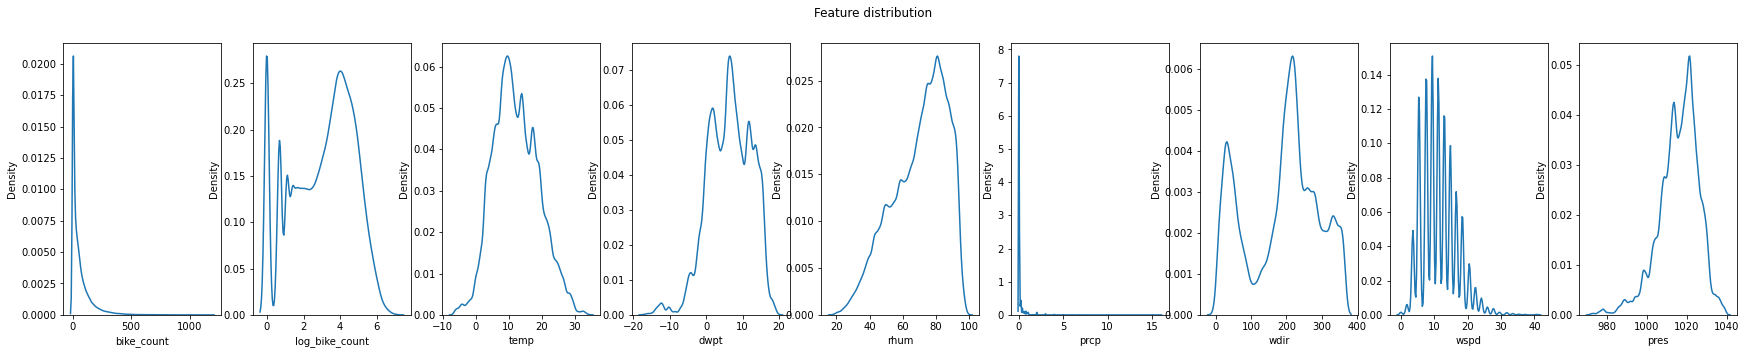

In [25]:
cols = ['bike_count','log_bike_count','temp','dwpt','rhum','prcp','wdir','wspd','pres']
def plot_distribution(data,columns,**kwargs ):
    """
    Function to plot a dataframe feature distribution.
    Input: 
    df - pandas DataFrame.
    columns - list of the df columns that should be plotted
    Output: multiple feature histograms
    
    """
    
    fig, axes = plt.subplots(ncols=len(columns),figsize=(30,5))
    for axs, col in zip(axes, columns):
        sns.kdeplot(data, ax=axs, x=col)
        #sns.histplot(data,ax=axs, x=col, kde=True, bins=50, binwidth=5)
    fig.suptitle('Feature distribution')
    
plot_distribution(train_merged,cols, kde=False)

> We can also see the variations in bike count depending on whether its a weekday/weekend/holiday

In [26]:
train_merged_non_weekend = train_merged[train_merged['weekend'] == 0]
train_merged_non_weekend = train_merged_non_weekend.drop(['holiday','weekend'],axis=1)
train_merged_is_weekend = train_merged[train_merged['weekend'] == 1]
train_merged_is_weekend = train_merged_is_weekend.drop(['holiday','weekend'],axis=1)
train_merged_is_holiday = train_merged[train_merged['holiday'] == 1]
train_merged_is_holiday = train_merged_is_holiday.drop(['holiday','weekend'],axis=1)
train_merged_non_holiday = train_merged[train_merged['holiday'] == 0]
train_merged_non_holiday = train_merged_non_holiday.drop(['holiday','weekend'],axis=1)


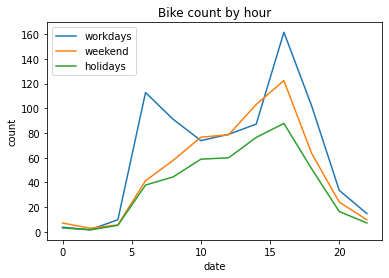

In [27]:
def hourly_plot(df,title):
    
    df.groupby(by=df.date.dt.hour)['bike_count'].mean().plot()
    plt.title(title)
    plt.ylabel('count')
    plt.legend(['workdays','weekend','holidays'],loc=2, fontsize = 'medium')
    
hourly_plot(train_merged_non_weekend, 'Bike count by hour')
hourly_plot(train_merged_is_weekend, 'Bike count by hour')
hourly_plot(train_merged_is_holiday, 'Bike count by hour')


> Correlation between various columns and 'log_bike_count'

In [28]:
corr = train_merged.corr()
corr_bike_count = corr['log_bike_count']
print(corr_bike_count)

site_id           0.019872
bike_count        0.738237
latitude          0.108380
longitude         0.044525
log_bike_count    1.000000
temp              0.116834
dwpt              0.121834
rhum             -0.005959
prcp             -0.015918
wdir             -0.014728
wspd             -0.097540
pres              0.032145
holiday          -0.046722
weekend          -0.070707
lockdown1        -0.044950
lockdown2         0.024604
season           -0.097064
is_night         -0.099998
hour_sin          0.025339
hour_cos          0.018828
month_sin        -0.108655
month_cos        -0.110986
Name: log_bike_count, dtype: float64


<AxesSubplot:>

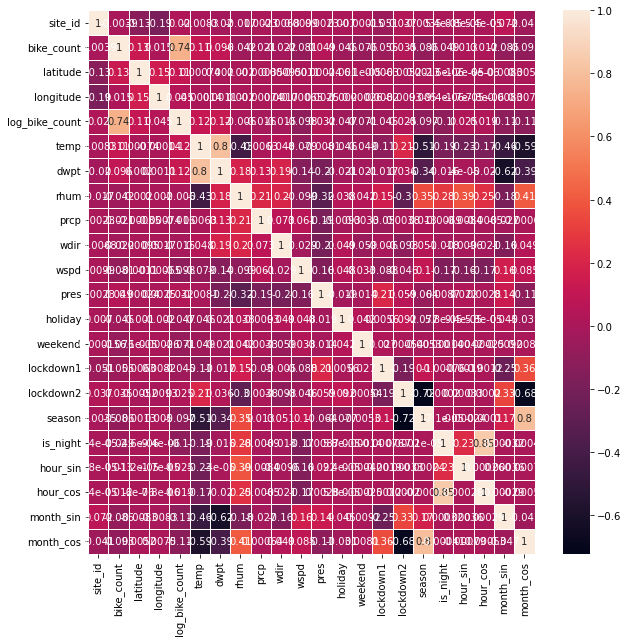

In [29]:
plt.figure(figsize = (10,10))
sns.heatmap(corr, linewidths=1, annot=True)

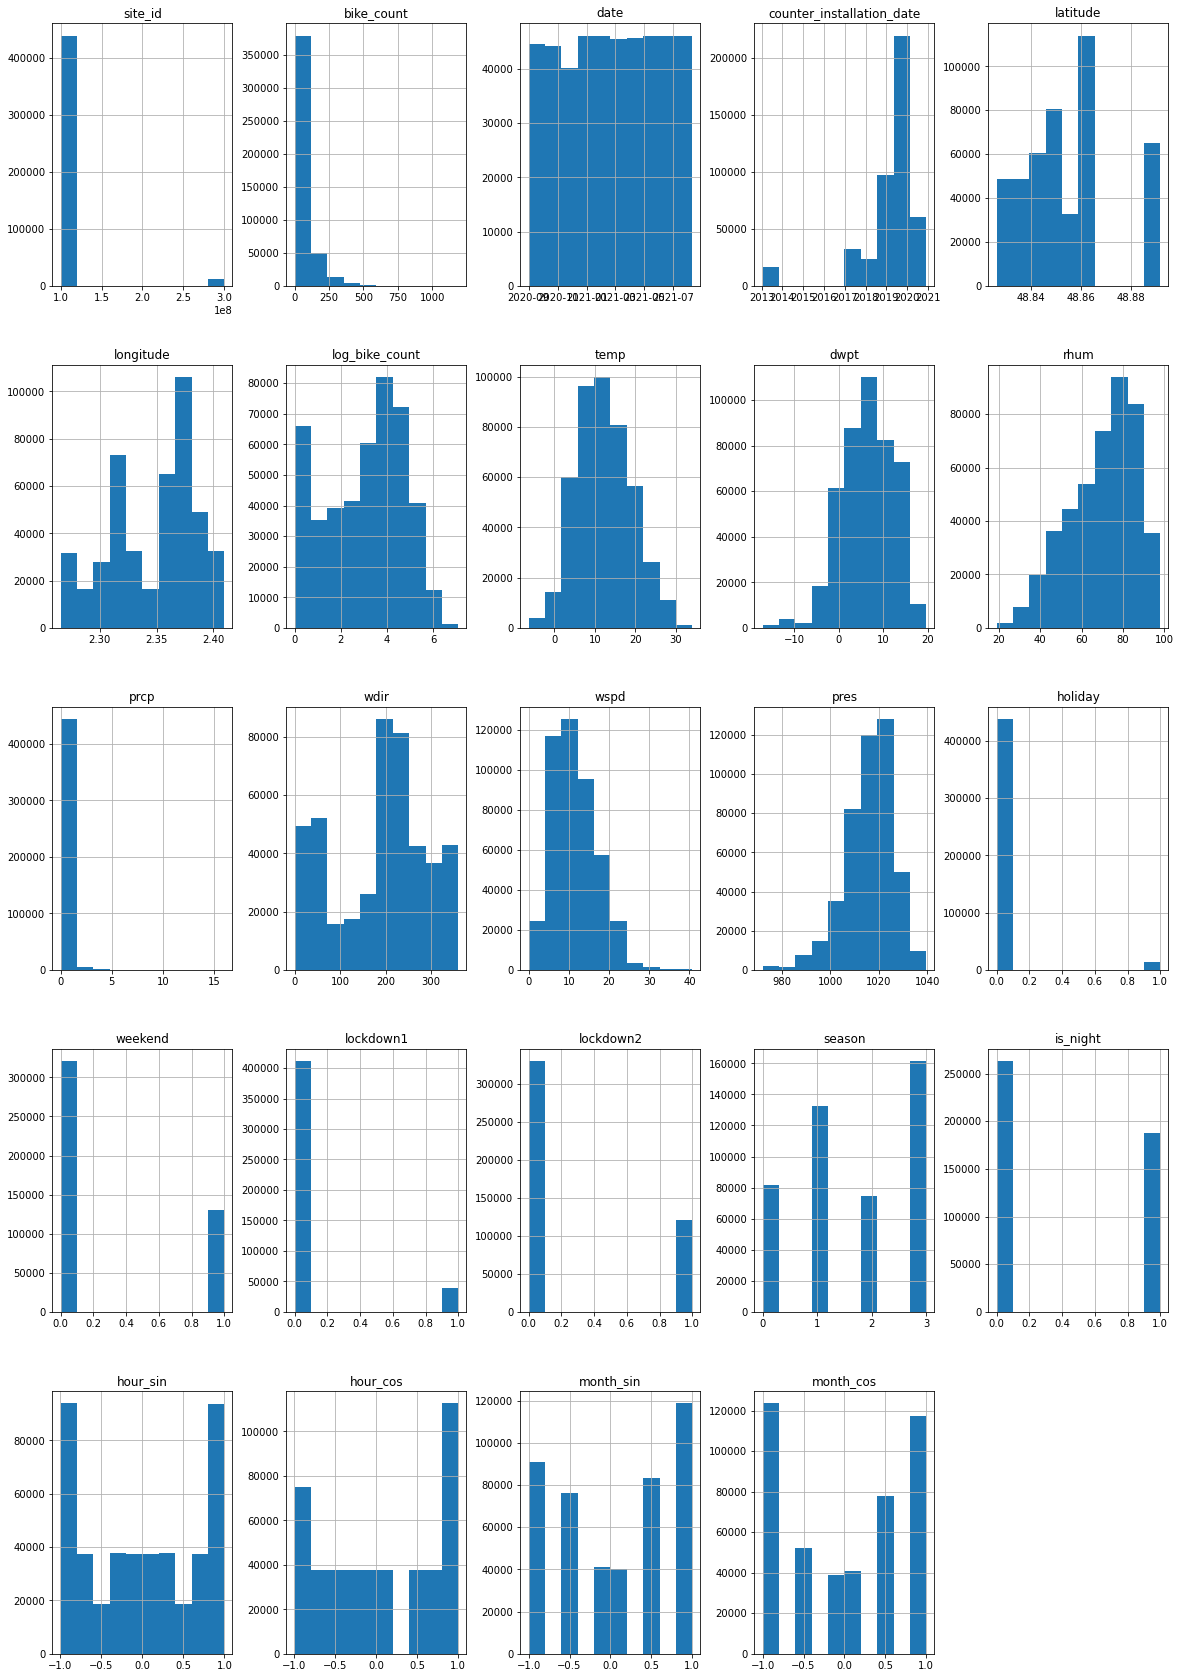

In [30]:
plot = train_merged.hist(figsize=(20, 30))